In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
from theano import tensor as tt, function, scan, shared

import rl

rl.plot_utils.set_mpl_defaults(matplotlib)
theano.config.compute_test_value = 'off' # Use 'warn' to activate this feature

import warnings
warnings.filterwarnings("ignore")

# Simulate data

In [3]:
# %% 2. Set up Dual-Learning-Rate Agent
# -------------------------------------
print("2. Set up Dual-Learning-Rate Agent")
print("----------------------------------")


# Use mean parameters from Lefebvre et al. (2017)
agent_vars = rl.agent.AgentVars(alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13))
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars, n_options=2)
print(agent)

2. Set up Dual-Learning-Rate Agent
----------------------------------
Dual learning rate agent (delta variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69


In [4]:
# %% 1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
# ------------------------------------------------------------------------
print("1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)")
print("---------------------------------------------------------------------")

# Set up the three different states (we changed the rewards from 1 to 0.5, for parameter values to better work with both tasks)
rv_states = {
    # 20:80
    0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
    # 80:20
    1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
    # 50:50
    2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [0.5, 0]},
}
rv_task_vars = rl.task.TaskVars(
    n_trials=100,
    n_blocks=2,
    n_options=2,
    states=rv_states,
    n_trials_reversal_min=10,  # minimum number of trials before reversal
    n_trials_reversal_max=16,  # maximum number of trials without reversal
    p_correct_reversal_min=0.7,  # minimum accuracy before reversal before `n_trials_reversal_max`
)

rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)
print(rv_task)

1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
---------------------------------------------------------------------
Reversal learning task with the states (rules):
  {0: {'p_r': [0.2, 0.8], 'a_correct': [1], 'rewards': [0.5, 0]}, 1: {'p_r': [0.8, 0.2], 'a_correct': [0], 'rewards': [0.5, 0]}, 2: {'p_r': [0.5, 0.5], 'a_correct': [0, 1], 'rewards': [0.5, 0]}}


In [5]:
# %% 1.2 Set up Multiple-State-Task (ms) from Lefebvre et al. (2017) Exp. 2
# -------------------------------------------------------------------------
print("1.2 Set up Multiple-State-Task (ms) from Lefebvre et al. (2017) Exp. 2")
print("----------------------------------------------------------------------")

# States (Conditions from Lefebvre et al. 2017, Experiment 2)
ms_states = {
    # 75/25
    0: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, -0.5],},
    # 25/25
    1: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, -0.5],},
    # 25/75
    2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, -0.5],},
    # 75/75
    3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, -0.5],},
}
n_states = len(ms_states)

n_blocks = 1

# Build state sequence: Each condition (pair) was shown 24 times
n_repeats = 24
state_sequence = np.repeat(np.arange(n_states), n_repeats)
# Randomize the order of conditions
np.random.shuffle(state_sequence.ravel())
state_sequence = state_sequence.reshape((n_blocks, -1))

# Number of blocks and trials are automatically read from `state_sequence.shape`
ms_task_vars = rl.task.TaskVars(
    states=ms_states, state_sequence=state_sequence, n_options=2
)

ms_task = rl.task.MultipleStateTask(task_vars=ms_task_vars)
print(ms_task)

1.2 Set up Multiple-State-Task (ms) from Lefebvre et al. (2017) Exp. 2
----------------------------------------------------------------------
Multiple-state learning task with the states:
  {0: {'p_r': [0.75, 0.25], 'a_correct': [0], 'rewards': [0.5, -0.5]}, 1: {'p_r': [0.25, 0.25], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}, 2: {'p_r': [0.25, 0.75], 'a_correct': [1], 'rewards': [0.5, -0.5]}, 3: {'p_r': [0.75, 0.75], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}}


3.1 Let the agent perform the RV-task
-------------------------------------


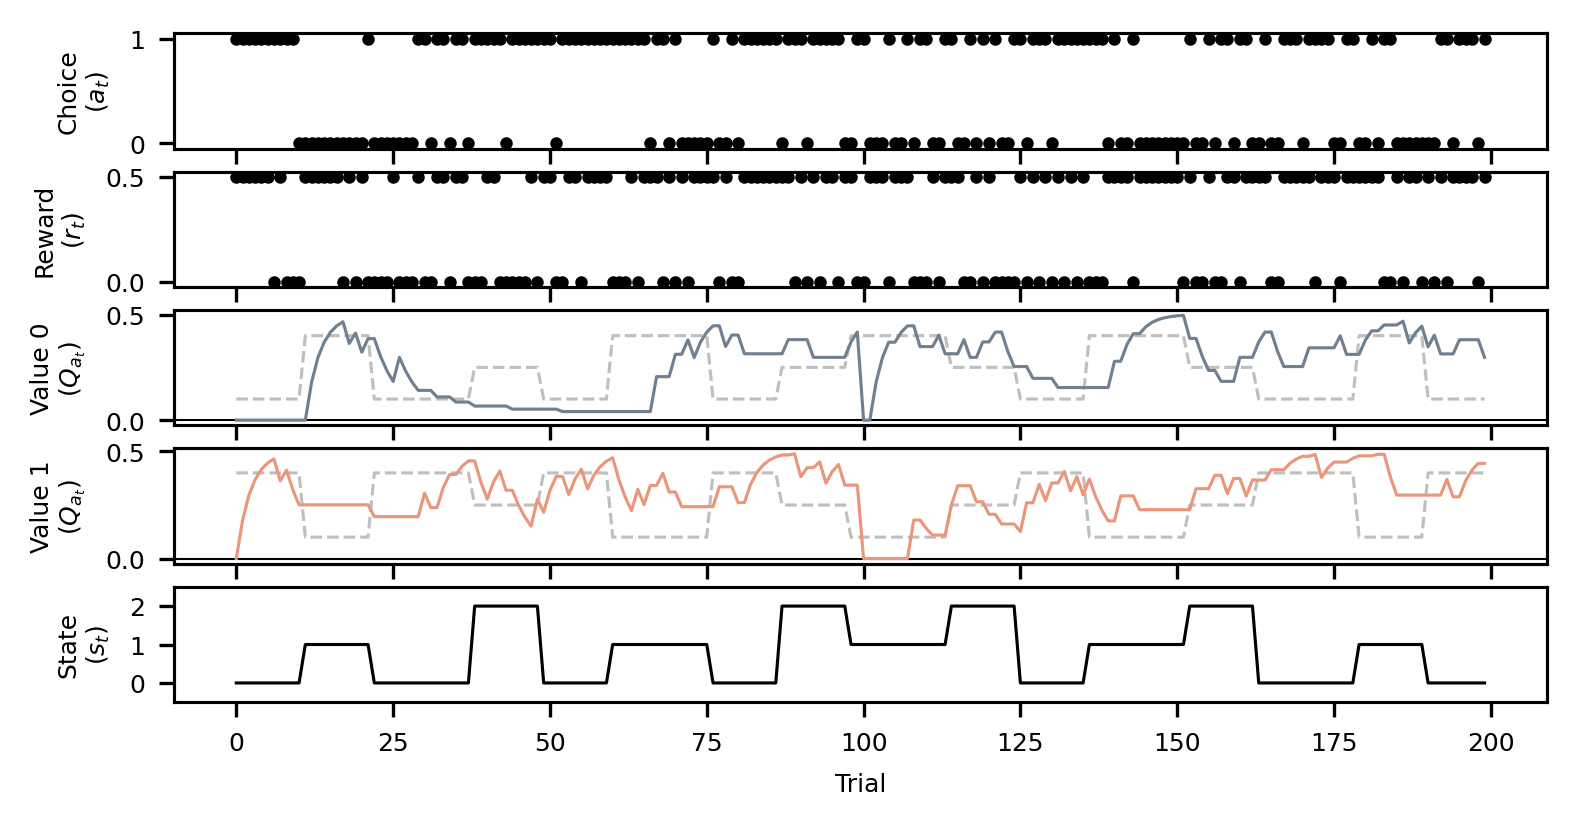

In [6]:
# %% 3.1 Let the agent perform the RV-task
# ----------------------------------------
print("3.1 Let the agent perform the RV-task")
print("-------------------------------------")

rv_data = rl.interaction.agent_task_interaction(rv_task, agent)
rl.plots.plot_data(rv_data);

3.2 Let the agent perform the MS-task
-------------------------------------


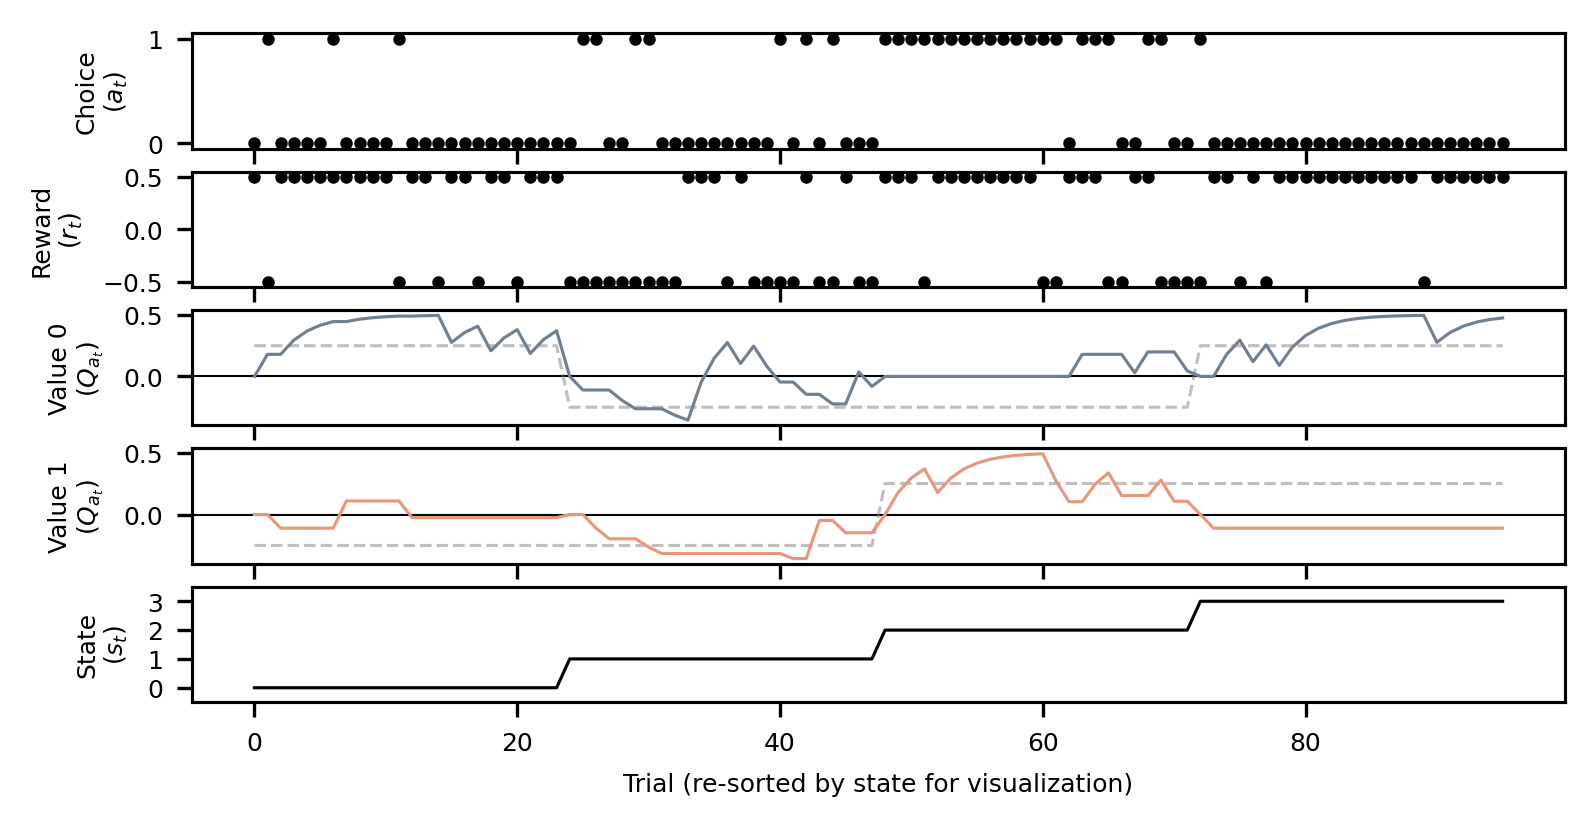

In [7]:
# %% 3.2 Let the agent perform the MS-task
# ----------------------------------------
print("3.2 Let the agent perform the MS-task")
print("-------------------------------------")

ms_data = rl.interaction.agent_task_interaction(ms_task, agent)
fig, axs = rl.plots.plot_data(ms_data.sort_values(["state", "trial"]).reset_index())
axs[-1].set_xlabel("Trial (re-sorted by state for visualization)");

# PyMC3 implementation

## Learning functions

In [11]:
# Simple Rescorla Wagner model functions, with one single learning rate
# We actually do not use these below.

def RW_learn(r_t, s_t, a_t, Q_t, alpha):
    """Simple RW learning rule.
    
    Args:
        r_t (float): current reward
        s_t (int): current state
        a_t (int): current action
        Q_t (numpy.array): current values
        alpha (float): learning rate
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - Q_t[s_t, a_t]
    Q_a_tplus1 = Q_t[s_t, a_t] + alpha * delta
    Q_tplus1 = tt.set_subtensor(Q_t[s_t, a_t], Q_a_tplus1)
    return Q_tplus1

def tt_RW_compute_Qs(r, s, a, alpha, Q0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        s (1d tensor): states
        a (1d tensor): actions
        alpha (float): learning rate
        Q0 (1d tensor): initial valuation

    Returns:
        2d tensor: matrix of valuations (n_trials x n_options)
    """
    Q_new, update = scan(
        lambda r, s, a, Q, alpha: RW_lean(r, s, a, Q, alpha),
        sequences=[r, s, a],
        non_sequences=[alpha],
        outputs_info=[Q0])
    return Q_new

In [12]:
# Rescorla Wagner Positive Negative (RWpn) functions.
# The first function implements a single learning step
# The second function implements learning over all trials, for a given set of parameters and data.

def RWpn_learn(r_t, s_t, a_t, Q_t, alpha_pos, alpha_neg):
    """RW learning rule with two learning rates:
        alpha_pos:  Following positive rewards (delta >= 0)
        alpha_neg: Following negative prediction errors (delta < 0)
    The model is described in Lefebvre et al. (2017)
    
    Args:
        r_t (float): current reward
        s_t (int): current state
        a_t (int): current action
        Q_t (2d tensor): current values (n_states x n_options)
        alpha_pos (float): learning rate for positive prediction errors
        alpha_neg (float): learning rate for negative prediction errors
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - Q_t[(s_t, a_t)]
    alpha = tt.switch(tt.lt(delta, 0), alpha_neg, alpha_pos)
    Q_a_tplus1 = Q_t[(s_t, a_t)] + alpha * delta
    Q_tplus1 = tt.set_subtensor(Q_t[(s_t, a_t)], Q_a_tplus1)
    return Q_tplus1

def tt_RWpn_compute_Qs(r, s, a, alpha_pos, alpha_neg, Q0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        s (1d tensor): states
        a (1d tensor): actions
        alpha_pos (float): learning rate for pos. prediction errors
        alpha_neg (float): learning rate for neg. prediction errors
        Q0 (2d tensor): initial valuation (n_states x n_options)

    Returns:
        3d tensor: matrix of valuations (n_trials x n_states x n_options)
    """
    Q_new, update = scan(
        RWpn_learn,
        sequences=[r, s, a],
        non_sequences=[alpha_pos, alpha_neg],
        outputs_info=[Q0])
    return Q_new

In [13]:
# Compile the function to see if it works

Q0 = tt.dmatrix('Q0')
Q = tt.dmatrix('Q')
a = tt.ivector('a')
s = tt.ivector('s')
r = tt.dvector('r')
alpha_pos = tt.dscalar('alpha_pos')
alpha_neg = tt.dscalar('alpha_neg')

Q_new = tt_RWpn_compute_Qs(r, s, a, alpha_pos, alpha_neg, Q0)

RWpn_compute_Qs = function([r, s, a, alpha_pos, alpha_neg, Q0], Q_new)

In [14]:
df = rv_data
n_states = 1
n_options = 2

r = df['r']
s = df['s'].values.astype(np.int32)  # Note that this is the agent's perceived state, not necessarily the true state
a = df['a'].values.astype(np.int32)
alpha_pos = 0.2
alpha_neg = 0.1
Q0 = np.full((n_states, n_options), 0.1)

Qs_pred = RWpn_compute_Qs(r, s, a, alpha_pos, alpha_neg, Q0)
Qs_pred[:3, :]

array([[[0.1   , 0.18  ]],

       [[0.1   , 0.244 ]],

       [[0.1   , 0.2952]]])

## Full PyMC3 model

In [18]:
with pm.Model() as RWpn:

    # Data
    r = pm.Data("r", df['r'].values)
    s = pm.Data("s", df['s'].values.astype(np.int32))    
    a = pm.Data("a", df['a'].values.astype(np.int32))
    
    # Priors
    alpha_pos = pm.Uniform("alpha_pos", 0, 1)     # Learning rate for pos. prediction errors
    alpha_neg = pm.Uniform("alpha_neg", 0, 1)     # Learning rate for neg. prediction errors
    beta  = pm.Gamma("beta", 0.01, 0.01)          # Inverse temperature
    Q0    = tt.zeros((n_states, n_options))       # Initial valuation, could be estimated, too, but we fix it here for simplicity
    
    # Likelihood
    Q   = tt_RWpn_compute_Qs(r, s, a, alpha_pos, alpha_neg, Q0)   # Valuation
    # Qs are post-learning, so they are not aligned with the choices
    # To align them, we need to insert Q0 in the first position
    Q_aligned = tt.concatenate([tt.reshape(Q0, (1, n_states, n_options)), Q], axis=0)
    Q_s = Q_aligned[tt.arange(r.size), s, :]                      # Reduce Q to the values of actions in the current state (n_trials + 1 x n_states x n_options -> n_trials x n_options)
    cp  = tt.nnet.softmax(beta * Q_s)                             # Choice probabilities for trials 
    obs = pm.Categorical("obs", p=cp, observed=a)                 # Observed choices


# Parameter estimation

In [23]:
# %% 4. Parameter estimation
# --------------------------
print("%% 4. Parameter estimation")
print("--------------------------")

for task, df in zip(["Reversal-learning", "Multiple-states"],
                    [rv_data, ms_data]):
    
    print(f"\n  {task}  Task")
    
    with RWpn:
        pm.set_data({"r": df["r"].values,
                     "s": df["s"].values.astype(np.int32),
                     "a": df["a"].values.astype(np.int32)})
        # MCMC
        trace = pm.sample()
    print(pm.summary(trace, hdi_prob=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


%% 4. Parameter estimation
--------------------------

  Reversal-learning  Task


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha_neg, alpha_pos]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 161 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
alpha_pos  0.566  0.178     0.250      0.925      0.005    0.004    1054.0   
alpha_neg  0.315  0.105     0.136      0.536      0.003    0.002     967.0   
beta       5.099  1.137     3.098      7.504      0.034    0.024    1128.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha_pos   997.0    1014.0     820.0    1.0  
alpha_neg   911.0    1002.0    1106.0    1.0  
beta       1128.0    1102.0    1163.0    1.0  

  Multiple-states  Task


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (200,) (96,) 

In [21]:
agent

Dual learning rate agent (delta variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69

# Conclusion

Our implemented Bayesian parameter estimation procedures generally seem to work to varying degrees of precision.